# INF200 Lecture No J05 / Model Dynamics

### Material by Jonas van den Brink
### Modified by Hans Ekkehard Plesser and Yngve Mardal Moe
### 14 January 2019

## Today's topics
- Classic population dynamics models
- Examples of BioSim Dynamics
- Analysis of BioSim Dynamics
- From discrete to continuous diffusion models

## Reasoning about the population dynamics model
It can often be useful to think about how the simulation will work in simplified settings. In this lecture, we will look at this, and think about how the simulation software should behave.

## Examples of BioSim dynamics

- The examples below have been prepared using Plesser's reference implementation

### Animals in a single Jungle cell

- 50 herbivores with random age and weight placed at start
- Simulated 50 years
- 5 carnivores with random age and weight placed
- Simulate 250 years
- Simulations with five different seeds
- See `examples/population_generator.py` for code generation populations

<img src="figures/mono_s1__00005.png" width=60%>
<img src="figures/mono_s2__00005.png" width=60%>
<img src="figures/mono_s3__00005.png" width=60%>
<img src="figures/mono_s4__00005.png" width=60%>
<img src="figures/mono_s5__00005.png" width=60%>




### Sample simulations

#### check_sim.py as posted
- 100 years only herbivores
- 100 years with also carnivores

<img src="figures/check_sim.png">

#### check_sim.py with longer times
- **200** years only herbivores
- **200** years with also carnivores

<img src="figures/check_sim_long.png">

### Complete simulation

- Full example island
- 200 herbivores and 50 carnivores, all age 5, weight 20, placed at (2,7) at beginning

<img src="figures/sas_s1_00000.png" width="70%">
<img src="figures/sas_s1_00200.png" width="70%">
<img src="figures/sas_s1_00399.png" width="70%">


### Migration only

- For testing purposes
- Particular parameter settings
    - No death, birth, or eating
    - All animals with age 5, weight 50
```python
    sim.set_animal_parameters('Herbivore',
                              {'mu': 1, 'omega': 0, 'gamma': 0,
                               'a_half': 1000})
    sim.set_animal_parameters('Carnivore',
                              {'mu': 1, 'omega': 0, 'gamma': 0,
                               'F': 0, 'a_half': 1000})
```
- 1000 herbivores and carnivores placed in center
- How do you think this map will look after many iterations?

<img src="figures/mig_00000.png" width="60%">
<img src="figures/mig_00001.png" width="60%">
<img src="figures/mig_00002.png" width="60%">
<img src="figures/mig_00003.png" width="60%">
<img src="figures/mig_00004.png" width="60%">
<img src="figures/mig_00005.png" width="60%">
<img src="figures/mig_00010.png" width="60%">
<img src="figures/mig_00029.png" width="60%">

- Correct, there will be approximately the same number of animals in each cell

## Exploring the BioSim Model

To have a better understanding of a complex and connected model, it is usefull to simplify it and break it into components, which is what we will do now.



### Herbivores

First we look at the herbivores. We only look at the standard set of parameters here

In [18]:
hp = {'w_birth': 8.,
      'sigma_birth': 1.5,
      'beta': 0.9,
      'eta': 0.05,
      'a_half': 40.,
      'phi_age': 0.2,
      'w_half': 10.,
      'phi_weight': 0.1,
      'mu': 0.25,
      'lambda': 1.,
      'gamma': 0.2,
      'zeta': 3.5,
      'xi': 1.2,
      'omega': 0.4,
      'F': 10.}

#### Fitness function
The Fitness function is defined as the product of two sigmoidal functions, one for age and one for weight.
    $$q^+ = \frac{1}{1+\exp[{\phi_{\rm age}({\rm age} - {\rm age}_{1/2})}]}, \qquad q^- = \frac{1}{1+\exp[-{\phi_{\rm weight}({\rm weight} - {\rm weight}_{1/2})}]}$$

If you look closer at the functions, the biggest difference between them is the sign of the exponent, this makes the age-function monotonically decreasing, and the weight-function monotonically increasing. Let us plot them to get a better view

In [19]:
def q(sgn, x, xhalf, phi):
    return 1. / (1. + np.exp(sgn * phi * (x - xhalf)))

def Phi(a, w, p=hp):
    return (q(+1, a, p['a_half'], p['phi_age'])
            * q(-1, w, p['w_half'], p['phi_weight']))

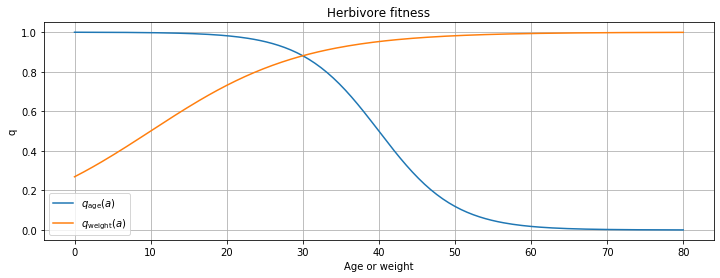

In [20]:
x = np.linspace(0, 80, 201);
plt.plot(x, q(+1, x, hp['a_half'], hp['phi_age']), label='$q_{\mathrm{age}}(a)$');
plt.plot(x, q(-1, x, hp['w_half'], hp['phi_weight']), label='$q_{\mathrm{weight}}(a)$');

plt.title('Herbivore fitness');
plt.legend();
plt.xlabel('Age or weight');
plt.ylabel('q');
plt.grid();

Interpretation: As the two functions are multiplied together to yield the fitness, an animal is fitter the younger and heavier it is. A starving or old animal can never be fit.

**From this plot, it might seem that fittest animals are heavy newborns. Is this the case?**

- By looking closer at the fitnesses of newborn and their parents at the time of birth, we notice that
    - Newborns are born with weight $\mathcal{N}(w_b, \sigma)$
        - Newborns usually have fitnesses in $\Phi(0, [w_b \pm 2\sigma]$).
    - To give birth, a parent needs a weight of at least $\zeta(w_b + \sigma)$.
    - Since we often have $N>10$ animals in a cell, each animal almost certainly gives birth as soon as it has the minimum weight required.
    - Thus, unless the appetite, $F$), is larger than $\zeta w_b$, the animals will not (on average) grow heavier than the birth-threshold.

**We can now look at the fitness of birth-giving animals**
- Weight just above the threshold to give birth
    - animal ate at beginning of year and just made it across threshold
    - weight: $\zeta(w_b + \sigma)$
- Weight well above the threshold to give birth
    - animal was just below threshold the previous year
    - lost weight at end of previous year
    - ate this year
    - weight: $(1-\eta)\zeta(w_b+\sigma) + \beta F$
- "Lowest" parent weight after birth (lightest parent, heaviest baby)
    - weight: $\zeta(w_b + \sigma) - \xi(w_b + 2\sigma)$
- "Highest" parent weight after birth (heaviest parent, lightest baby)
    - weight: $(1-\eta)\zeta(w_b + \sigma) + \beta F - \xi(w_b - 2\sigma)$

In [17]:
def plot_parent_fitness(age, clr):
    lo = ( hp['zeta'] * (hp['w_birth']+hp['sigma_birth'])
           - hp['xi'] * (hp['w_birth']+2*hp['sigma_birth']) )
    hi = ( (1-hp['eta'])*hp['zeta']*(hp['w_birth']+hp['sigma_birth'])
                     + hp['beta']*hp['F']
                     - hp['xi']*(hp['w_birth']-2*hp['sigma_birth']) )
    plt.fill_between(x, Phi(age*np.ones_like(x), lo), 
                        Phi(age*np.ones_like(x), hi), 
                 color=clr, alpha=.2, label=r'Parent fitness ($a={}$)'.format(age))

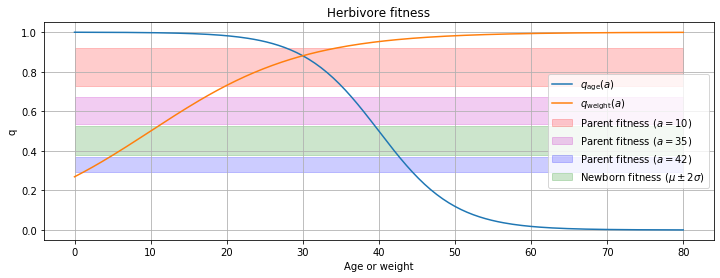

In [14]:
x = np.linspace(0, 80, 201);
plt.plot(x, q(+1, x, hp['a_half'], hp['phi_age']), label='$q_{\mathrm{age}}(a)$');
plt.plot(x, q(-1, x, hp['w_half'], hp['phi_weight']), label='$q_{\mathrm{weight}}(a)$');

plot_parent_fitness(10, 'r')
plot_parent_fitness(35, 'm')
plot_parent_fitness(42, 'b')
plt.fill_between(x, 
                 Phi(np.zeros_like(x), hp['w_birth']-2*hp['sigma_birth']), 
                 Phi(np.zeros_like(x), hp['w_birth']+2*hp['sigma_birth']), 
                 color='g', alpha=.2, label=r'Newborn fitness $(\mu\pm 2\sigma)$')


plt.title('Herbivore fitness');
plt.legend();
plt.xlabel('Age or weight');
plt.ylabel('q');
plt.grid();

**Observations from the figure:**
- Up to age 35, parents are fitter than newborns after birth (weight is more important than age)
- Beyond age 42, parents are less fit than newborns (age more important than weight)
- Assuming ready supply of newborns, parents will starve past approximately 40 years of age

### Stationary weight for herbivores
- Under the following assumptions
    - Constant number of animals (no birth/death)
    - Infinite fodder

- How heavy will the animals become?

- Let $w_0$ be the birth weight of the animal, then the weight at the end of the first and second year is
\begin{align}
w_1 &= (1-\eta)(w_0 + \beta F), \\
w_2 &= (1-\eta)(w_1 + \beta F) = (1-\eta)((1-\eta)(w_0 + \beta F) + \beta F).
\end{align}
And for year $n$:
\begin{align}
w_n &= (1-\eta)(w_{n-1} + \beta F) = (1-\eta)^n w_0 + \beta F \sum_{k=1}^{n}(1-\eta)^k\\
    &= (1-\eta)^n w_0 + \beta F \frac{(1-\eta)-(1-\eta)^{n+1}}{\eta}
\end{align}

This formula for $w_n$ is a testable prediction for the time evolution of the BioSim model with given parameters.

**The stationary weight**

The stationary weight, $\bar{w}$, is the 'stable' weight where the weight is not changing any more. To find $\bar{w}$, solve
$$ w_n = w_{n+1}, $$
with respect to $w_n$. To do that, we input the formula above and get
$$\bar{w} = (1-\eta)(\bar{w} + \beta F)$$
Which can be solved, giving us the following formula
        $$\bar{w} = \frac{1-\eta}{\eta}\beta F.$$

**Alternative approach**:

We obtain the same result by taking
$$\bar{w}=\lim_{n\to\infty}w_n=\beta F\frac{1-\eta}{\eta}$$

**For standard parameters, we have:**

In [21]:
(1-hp['eta'])/hp['eta'] * hp['beta'] * hp['F']

170.99999999999997

- This is a testable prediction.

### Death of newborns

- For young animals ($\lt 20$ years), weight determines fitness
- Newborns can survive only if they manage to feed in their first year, otherwise their fitness drops due to weight loss and they have an even smaller chance to feed the next year
- What happens to newborns that do not get to eat at all?

- $n$ years after birth, the probability of death is
$$\Omega_n = \omega(1 - \Phi(n, w_n))$$
- The probability to surive at least $n$ years is then
$$\Pi_{k=1}^n(1-\Omega_k)$$
- And the probability that the animal dies at the exactly the end of year $n$ is 
$$\Omega_n\Pi_{k=1}^{n-1}(1-\Omega_k).$$
- Since $\Omega_k$ depends on $\Phi(k, w_k)$ with $w_k=(1-\eta)^k w_0$ (animal does not feed), it is challenging to write out the expression for the survival or death probabilites.
- We can compute them, assuming an average birth weight for simplicity


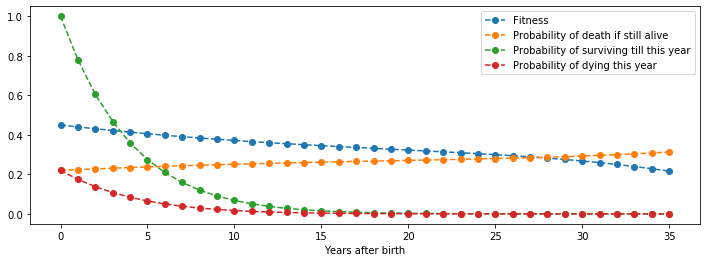

In [81]:
age = np.arange(0, 35.5)
weight = hp['w_birth'] * (1-hp['eta'])**age
fit = Phi(age, weight)
death_prob = hp['omega'] * ( 1 - fit )
survival_prob = np.cumprod(1-np.concatenate(([0], death_prob[:-1])))
dies_now_prob = death_prob*survival_prob

plt.plot(age, fit, 'o--', label='Fitness')
plt.plot(age, death_prob, 'o--', label='Probability of death if still alive')
plt.plot(age, survival_prob, 'o--', label='Probability of surviving till this year')
plt.plot(age, dies_now_prob, 'o--', label='Probability of dying this year')

plt.xlabel('Years after birth')
plt.legend();

- The chance to survive up to 25 years is very small
- Fitness changes only slowly
- The average lifetime, i.e., average time at death, is

In [82]:
np.sum(age*dies_now_prob)

3.331583242232593

- Newborns who are not fed die on average after 3.3 years
- To see the effect of different birth weights, we consider a large and a small birth weight

We now create a function that computes this to see the effect of birth-weight on survival

In [83]:
def average_age(birth_weight):
    age = np.arange(0, 30.5)
    fit = Phi(age, birth_weight)
    death_prob = hp['omega'] * ( 1 - fit )
    survival_prob = np.cumprod(1-np.concatenate(([0], death_prob[:-1])))
    dies_now_prob = death_prob*survival_prob
    return np.sum(age*dies_now_prob)


print("Lifetime (low birthweight):", average_age(hp['w_birth']-2*hp['sigma_birth']))
print("Lifetime (high birthweight):", average_age(hp['w_birth']+2*hp['sigma_birth']))

Lifetime (low birthweight): 3.0099400763231836
Lifetime (high birthweight): 4.210716163955569


- Lifetimes depend on birth weight
- Roughly ranging from 3 to 4 years

## Classic models

### Lotka-Volterra model

- Classic model of predator-prey population dynamics
- Each species is represented by a single density variable
- Dynamics are described by coupled, non-linear differential equations
\begin{align}
\dot{x} &= \alpha x - \beta x y  \\
\dot{y} &= \delta xy - \gamma y 
\end{align}
where $x$ is prey and $y$ is predator.
- Notes:
    - Solutions are continuous functions
    - Fractional values for $x$ and $y$ are possible, and animals never become extinct
    - One can remove three out of the four parameters by re-scaling
- See also [Wikipedia](https://en.wikipedia.org/wiki/Lotka–Volterra_equations)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = (12, 4)

In [5]:
def du_dt(u, t=0):
    alpha = 1.0 # growth of prey
    beta = 0.1  # rate of predation
    delta = 0.075 # growth of predators
    gamma = 1.5 # decay of predators

    x, y = u
    return np.array([alpha*x - beta*x*y, delta*x*y - gamma*y])

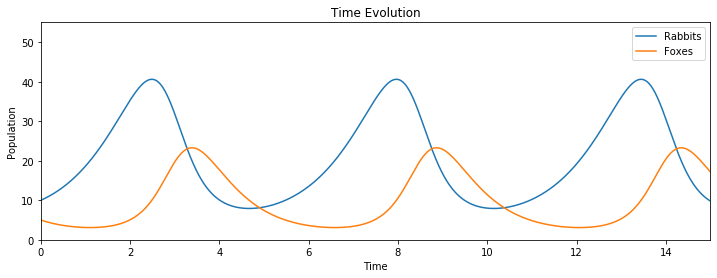

In [15]:
# Set time-points to where the differential equation should be solved
t = np.linspace(0, 15, 100001)

# Set initial conditions
init_num_rabbits = 10
init_num_foxes = 5
init_population = init_num_rabbits, init_num_foxes

# Solve the differential equation
u = scipy.integrate.odeint(du_dt, init_population, t)

rabbit, fox = u[:, 0], u[:, 1]

plt.plot(t, rabbit)
plt.plot(t, fox)
plt.legend(['Rabbits', 'Foxes'])
plt.axis([0, 15, 0, 55])
plt.title('Time Evolution')
plt.xlabel('Time')
plt.ylabel('Population');

## It is also useful to consider the phase-space representation of this data

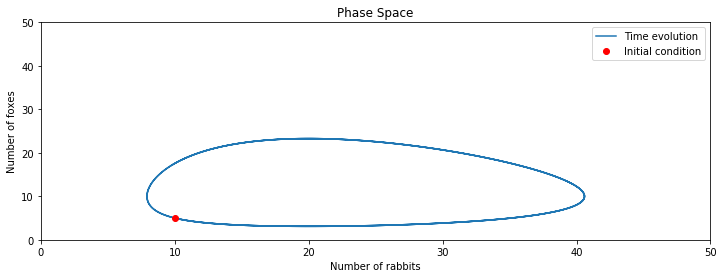

In [16]:
plt.plot(rabbit, fox)
plt.title('Phase Space')
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.axis([0, 50, 0, 50])
plt.plot(10, 5, 'ro')
plt.legend(['Time evolution', 'Initial condition']);

We can now look at the phase-space representation of many different initial conditions

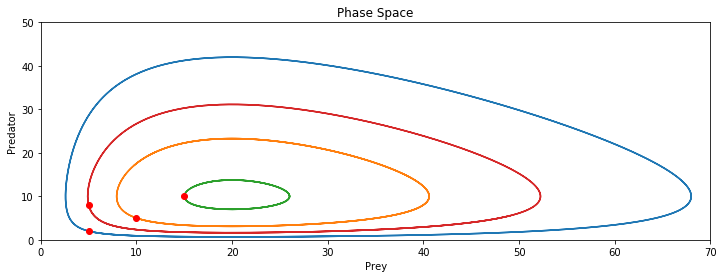

In [8]:
for u0 in [(5, 2), (10, 5), (15, 10), (5, 8)]:
    u = scipy.integrate.odeint(du_dt, u0, t)
    plt.plot(u[:,0], u[:,1])
    plt.plot(u0[0], u0[1], 'ro')

plt.title('Phase Space')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.axis([0, 70, 0, 50]);

We can form a vector field that describes the behaviour of the model

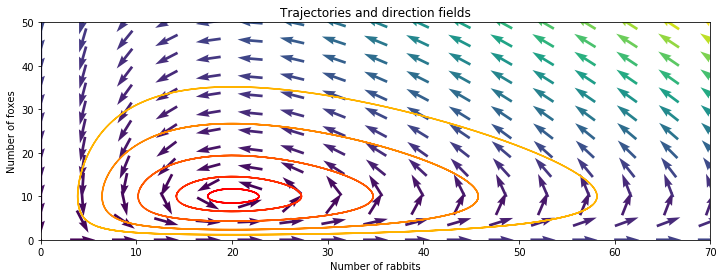

In [9]:
# Plot trajectories
values = ((6, 3), (9, 4), (12, 6), (15, 8), (18, 9))
colors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))

for u0, col in zip(values, colors):
    u = scipy.integrate.odeint(du_dt, u0, t)
    plt.plot(u[:,0], u[:,1], color=col)

# Plot phase space direction arrows
x = np.linspace(0, 70, 17)
y = np.linspace(0, 50, 13)
X, Y = np.meshgrid(x, y)
DX, DY = du_dt([X, Y])

# Normalize direction vectors
M = np.hypot(DX, DY)
M[M == 0] = 1.                                 # Avoid zero division errors
DX /= M                                        # Normalize each arrows
DY /= M

plt.title('Trajectories and direction fields')
plt.quiver(X, Y, DX, DY, M, pivot='mid', cmap=plt.cm.viridis)
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.axis([0, 70, 0, 50]);


#### The Lotka-Volterra is quite different from the BioSim model

- No spatial distribution (comparable to a single BioSim cell)
- Continuous, rather than discrete, in time
- Assumes infinite fodder for the prey/herbivores
- No random elements, it is a fully deterministic model